##Import Packages

In [51]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

##Import Data

In [52]:
#Loading the dataset
df = pd.read_csv('Spam SMS Collection', sep='\t', names=['label', 'message'])

In [53]:
#First five observations
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
#Shape of the dataset
df.shape

(5572, 2)

In [55]:
#Count of output feature
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [56]:
#Create list of punctuation marks
import string
punctuations=string.punctuation

#Create list of stopwords
nlp=spacy.load('en')
stop_words=spacy.lang.en.stop_words.STOP_WORDS

#Load English tokenizer, tagger, parser, NER and word vectors
parser=English()

#Create tokenizer function
def spacy_tokenizer(sentence):
  #Creating our token object, which is used to create documents with linguistic annotations.
  mytokens=parser(sentence)
  #Lemmatizing each token and converting each token into lowercase
  mytokens=[word.lemma_.lower().strip() if word.lemma_!='-PRON' else word.lower_ for word in mytokens]
  #Removing stopwords
  mytokens=[word for word in mytokens if word not in stop_words and word not in punctuations]
  #Return preprocessed list of tokens
  return mytokens

In [57]:
#To further clean our text data, we’ll also want to create a custom transformer for removing initial and end spaces and converting text into lower case.
from sklearn.base import TransformerMixin
class predictors(TransformerMixin):
  def transform(self,X, **transform_params):
    return[clean_text(text)for text in X]

  def fit(self,X,y=None, **fir_params):
    return self
  
  def get_params(self,deep=True):
    return {}
#Basic function to clean the text
def clean_text(text):
  #Removing spaces and converting text into lowercase
  return text.strip().lower()

##Vectorization

In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vector=CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,3))
tfidf_vector= TfidfVectorizer(tokenizer=spacy_tokenizer)

##Train Test Split

In [59]:
from sklearn.model_selection import train_test_split
X=df['message']
y=pd.get_dummies(df['label'])
y=y.drop(['spam'],1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

##Pipeline

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc=SVC(class_weight='balanced')
params={'kernel':['linear','rbf','poly','sigmoid'],'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
gs_svc=GridSearchCV(svc,params)

In [61]:
pipe= Pipeline([('cleaner', predictors()),
                 ('vectorizer',tfidf_vector),
                 ('classifier', gs_svc)])
pipe.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fc6c299ce80>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False

Accuracy: 0.9849246231155779
Precision: 0.9933938893476466
Recall: 0.9893092105263158


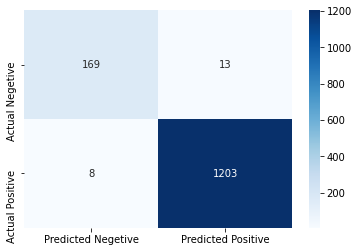

In [62]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
predicted=pipe.predict(X_test)
print('Accuracy:',metrics.accuracy_score(predicted,y_test))
print('Precision:',metrics.precision_score(predicted,y_test))
print('Recall:',metrics.recall_score(predicted,y_test))

cfm=metrics.confusion_matrix(y_test,predicted)
lbl1=['Predicted Negetive', 'Predicted Positive']
lbl2=['Actual Negetive', 'Actual Positive']
sns.heatmap(cfm, annot=True, cmap='Blues',fmt='d',xticklabels=lbl1,yticklabels=lbl2)
plt.show()